In [6]:
from Ti import Ti
from nellinetwork import Network
import numpy as np


In [11]:
num_items = 7
items_n = num_items

# Nelli Parameters

In [13]:

mode = "main" # "lazy-regime", "two-readouts", "fixed-inputs"

# Random seeds
seeds_n = 20
mds_seed = 1

# # Number of input items
# items_n = 12

# Experiment details
training_blocks = 16 if mode == "two-readouts" else 8
trials = 60
training_length = 2 * training_blocks * trials
stitching_steps = 20

# Network hyperparameters
readouts = 2 if mode == "two-readouts" else 1
h1_size = 20

if mode == "lazy-regime":
    w1_weight_std = np.sqrt(6. / items_n)
    w2_weight_std = np.sqrt(10. / h1_size)
else:
    w1_weight_std = 0.025 * np.sqrt(1 / items_n)
    w2_weight_std = np.sqrt(1 / h1_size)

learning_rate = 0.03 if mode == "lazy-regime" else 0.05

# Parameter space for gridsearch
gammas = np.concatenate([[0], np.geomspace(1e-4, 1, 69)])
ss = np.geomspace(1e-2, 100, 65)

In [16]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import os

# -----------------------------
# Reproducibility (optional but recommended)
# -----------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -----------------------------
# Dataset wrapper
# -----------------------------
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data   = torch.as_tensor(data, dtype=torch.float32)
        self.labels = torch.as_tensor(labels, dtype=torch.float32)

    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i], self.labels[i]

# -----------------------------
# Helpers for 1-indexed pairs
# -----------------------------
def pair_vec_1based(i1, j1, n, device):
    """Concatenated one-hots for (i1, j1), 1-indexed, length 2n.
       Returns shape (1, 2n) on the requested device."""
    i0, j0 = i1-1, j1-1
    x = torch.zeros(2*n, dtype=torch.float32)
    x[i0] = 1.0
    x[n+j0] = 1.0
    return x.unsqueeze(0).to(device)

def score_and_label_from_logits(logits):
    s = logits.view(-1).item()
    c = 1 if s >= 0 else -1
    return s, c

# # -----------------------------
# # Model: Depth 3 architecture with frozen first 3 layers
# # -----------------------------
# class Network(nn.Module):
#     def __init__(self, n, hidden=1000, hidden2=1000, hidden3=1000):
#         super().__init__()
#         self.fc1 = nn.Linear(2*n, hidden)     # will be FROZEN (first frozen layer)
#         self.act1 = nn.ReLU()
#         self.fc2 = nn.Linear(hidden, hidden2)  # will be FROZEN (second frozen layer)
#         self.act2 = nn.ReLU()
#         self.fc3 = nn.Linear(hidden2, hidden3) # will be FROZEN (third frozen layer)
#         self.act3 = nn.ReLU()
#         self.fc4 = nn.Linear(hidden3, 1)      # TRAINABLE (only trainable layer)

#     def forward(self, x)
#         x = self.act1(self.fc1(x))  # first frozen layer
#         x = self.act2(self.fc2(x))  # second frozen layer
#         x = self.act3(self.fc3(x))  # third frozen layer
#         return self.fc4(x)          # only trainable layer

# -----------------------------
# Setup
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"


p, q = 5, 3
hidden = 1000
runs = 10
epochs = 8000
loss_fn = nn.MSELoss()
lr=1e-1
freeze_hidden_layers = True
nonlinearity = 'ReLU'
initialization = 'NTK'
depth = 3

# Your data creators
data = Ti.createData(num_items)
TDExp        = Ti.createTDTotalExp(data, p, q, num_items)
TDLabelsExp  = Ti.createTDLabelsTotalExp(data)

dataset   = CustomDataset(TDExp, TDLabelsExp)

# Seeded DataLoader (stable shuffles)
g = torch.Generator()
g.manual_seed(0)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, generator=g, num_workers=0)

# -----------------------------
# CONFIGURABLE CSV FILENAME
# -----------------------------

def set_csv_filename(p, q, hidden, lr, nonlinearity, freeze_hidden_layers, initialization):
    """
    Sets the CSV_FILENAME global variable based on the provided parameters.
    Args:
        p (int): First dimension parameter.
        q (int): Second dimension parameter.
        hidden_neurons (int): Number of neurons in the hidden layer.
        lr (float): Learning rate.
        nonlinearity (str): Name of the nonlinearity (e.g., 'tanh', 'relu').
        freeze_layers (bool): Whether layers are frozen.
        initialization: Rich or Lazy
    """
    global CSV_FILENAME
    freeze_str = "freeze" if freeze_hidden_layers else "nofreeze"
    CSV_FILENAME = f"critical_pairs_{p}_{q}_{hidden}_{lr}_{nonlinearity}_{freeze_str}_{initialization}_depth{depth}"
    print(CSV_FILENAME)


set_csv_filename(p, q, hidden, lr, nonlinearity, freeze_hidden_layers, initialization)
# The full path will be: run_csvs/{CSV_FILENAME}.csv

# Ensure the directory for CSV output exists before any file operations
csv_dir = "run_csvs"
os.makedirs(csv_dir, exist_ok=True)

# Build the CSV path using the configurable filename
csv_path = os.path.join(csv_dir, f"{CSV_FILENAME}.csv")

# Ensure the CSV file exists (create if not)
if not os.path.exists(csv_path):
    with open(csv_path, "w", newline="") as f:
        pass  # Just create the empty file

# -----------------------------
# Train multiple runs (to check stability)
# -----------------------------
train_scores_last, test_scores_last = [], []

# ---- Collect all runs' data for single CSV ----
all_rows = []
header = ["run", "step", "loss", "train_margin", "test_margin"]

print(f"Starting training... Results will be saved to: {csv_path}")
print("="*60)

for run in range(runs):
    # fresh model each run
    model = Network(num_items, hidden, w1_weight_std, w2_weight_std).to(device)

    opt = torch.optim.SGD(model.parameters(), lr=lr)

    # Tracked pairs
    train_pair = (q, q+1)   # (3,4)
    test_pair  = (q-1, p)   # (2,5)

    x_train_vec = pair_vec_1based(*train_pair, num_items, device)
    x_test_vec  = pair_vec_1based(*test_pair,  num_items, device)

    loss_history, train_scores, test_scores = [], [], []

    # Step 0: loss before training
    model.eval()
    with torch.no_grad():
        X0, y0 = next(iter(dataloader))
        X0, y0 = X0.to(device), y0.to(device).view(-1, 1)
        init_pred = model(X0)
        init_loss = loss_fn(init_pred, y0).item()
        loss_history.append(init_loss)
        s_tr, _ = score_and_label_from_logits(model(x_train_vec))
        s_te, _ = score_and_label_from_logits(model(x_test_vec))
        train_scores.append(s_tr); test_scores.append(s_te)
    print(f"[Run {run:02d}] Step 0 MSE: {init_loss:.6f}")

    # Training loop (ONLY last layer fc4 is trainable)
    model.train()
    for epoch in range(epochs):
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).view(-1, 1)

            opt.zero_grad()
            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()

            # record loss & tracked logits
            loss_history.append(loss.item())
            with torch.no_grad():
                s_tr = model(x_train_vec).item()
                s_te = model(x_test_vec).item()
                train_scores.append(s_tr); test_scores.append(s_te)

    # ---- Collect run's data for single CSV ----
    steps = range(len(loss_history))
    for i, (loss, tr, te) in enumerate(zip(loss_history, train_scores, test_scores)):
        all_rows.append([run, i, loss, tr, te])

    # ---- Plots per run (only for first 2 runs) ----
    if run < 2:
        plt.figure(figsize=(7,4))
        plt.plot(steps, loss_history, label="MSE Loss")
        plt.xlabel("Training step"); plt.ylabel("Loss"); plt.title(f"Run {run} - Training Loss (MSE)")
        plt.grid(True, alpha=0.3); plt.legend(); plt.show()

        plt.figure(figsize=(7,4))
        plt.plot(steps, train_scores, '--', label=f"Score train {train_pair}")
        plt.plot(steps, test_scores,  '-.', label=f"Score test {test_pair}")
        plt.xlabel("Training step"); plt.ylabel("Logit score (raw)")
        plt.title(f"Run {run} - Tracked Predictions")
        plt.axhline(0, color='k', linestyle=':')
        plt.grid(True, alpha=0.3); plt.ylim(-1, 1); plt.legend(); plt.show()

    train_scores_last.append(train_scores[-1])
    test_scores_last.append(test_scores[-1])

# ---- Write all runs to a single CSV ----
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(all_rows)

print("="*60)
print(f"✓ Saved all runs to {csv_path}")
print(f"  Total data points: {len(all_rows)}")
print(f"  Runs completed: {runs}")
print("="*60)

# Summary across runs
plt.figure(figsize=(7,4))
plt.plot(train_scores_last, marker='o', label='Train Scores (last)')
plt.plot(test_scores_last, marker='s', label='Test Scores (last)')
plt.xlabel("Run"); plt.ylabel("Final Score")
plt.title("Final Train and Test Scores Across Runs (last-layer only, depth-3 frozen)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()


inputTotal: [[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1], [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]]
exception: [[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]
labels: [1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1]
labelsExp: [1, -1]
critical_pairs_5_3_1000_0.1_ReLU_freeze_NTK_depth3
Starting training... Results will be saved to: run_csvs\critical_pairs_5_3_1000_0.1_ReLU_freeze_NTK_depth3.csv


TypeError: Network.forward() missing 1 required positional argument: 'item_2'

In [ ]:
# -----------------------------
# Symbolic Distance Analysis
# -----------------------------
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def get_symbolic_distance(i, j):
    """Calculate symbolic distance between pair (i, j)"""
    return abs(j - i)

def get_all_pairs_by_distance(num_items):
    """Get all valid pairs organized by symbolic distance"""
    pairs_by_distance = defaultdict(list)

    for i in range(1, num_items + 1):
        for j in range(1, num_items + 1):
            if i != j:  # Exclude diagonal pairs
                distance = get_symbolic_distance(i, j)
                if num_items - distance > 0:  # Condition: n - sd > 0
                    pairs_by_distance[distance].append((i, j))

    return pairs_by_distance

# Get all pairs by distance for our setup
pairs_by_distance = get_all_pairs_by_distance(num_items)

print("Pairs organized by symbolic distance:")
print("="*50)
for distance in sorted(pairs_by_distance.keys()):
    pairs = pairs_by_distance[distance]
    print(f"Distance {distance}: {len(pairs)} pairs")
    print(f"  Pairs: {pairs}")
    print(f"  Condition n - sd = {num_items} - {distance} = {num_items - distance} > 0: ✓")
    print()

# Show which distances we'll analyze
valid_distances = sorted(pairs_by_distance.keys())
print(f"Valid symbolic distances to analyze: {valid_distances}")
print(f"Total distances: {len(valid_distances)}")


Pairs organized by symbolic distance:
Distance 1: 12 pairs
  Pairs: [(1, 2), (2, 1), (2, 3), (3, 2), (3, 4), (4, 3), (4, 5), (5, 4), (5, 6), (6, 5), (6, 7), (7, 6)]
  Condition n - sd = 7 - 1 = 6 > 0: ✓

Distance 2: 10 pairs
  Pairs: [(1, 3), (2, 4), (3, 1), (3, 5), (4, 2), (4, 6), (5, 3), (5, 7), (6, 4), (7, 5)]
  Condition n - sd = 7 - 2 = 5 > 0: ✓

Distance 3: 8 pairs
  Pairs: [(1, 4), (2, 5), (3, 6), (4, 1), (4, 7), (5, 2), (6, 3), (7, 4)]
  Condition n - sd = 7 - 3 = 4 > 0: ✓

Distance 4: 6 pairs
  Pairs: [(1, 5), (2, 6), (3, 7), (5, 1), (6, 2), (7, 3)]
  Condition n - sd = 7 - 4 = 3 > 0: ✓

Distance 5: 4 pairs
  Pairs: [(1, 6), (2, 7), (6, 1), (7, 2)]
  Condition n - sd = 7 - 5 = 2 > 0: ✓

Distance 6: 2 pairs
  Pairs: [(1, 7), (7, 1)]
  Condition n - sd = 7 - 6 = 1 > 0: ✓

Valid symbolic distances to analyze: [1, 2, 3, 4, 5, 6]
Total distances: 6


In [ ]:
# -----------------------------
# Enhanced Training with Symbolic Distance Analysis
# -----------------------------

# Create enhanced CSV filename for symbolic distance analysis
CSV_FILENAME_SYMBOLIC = f"{CSV_FILENAME}_symbolic_distances"
csv_path_symbolic = os.path.join(csv_dir, f"{CSV_FILENAME_SYMBOLIC}.csv")

# Prepare data structures for tracking all pairs
all_pair_vectors = {}
all_pair_labels = {}

# Pre-compute pair vectors and expected labels for all pairs
print("Pre-computing pair vectors and labels...")
for distance in valid_distances:
    pairs = pairs_by_distance[distance]
    for pair in pairs:
        i, j = pair
        # Get the pair vector
        pair_vec = pair_vec_1based(i, j, num_items, device)
        all_pair_vectors[pair] = pair_vec

        # Determine expected label based on the original data
        # We need to check if this pair appears in our training data
        pair_found = False
        expected_label = 0

        # Check in TDExp and TDLabelsExp to find the expected label
        for idx, (data_vec, label) in enumerate(zip(TDExp, TDLabelsExp)):
            # Convert to tensor for comparison
            data_tensor = torch.tensor(data_vec, dtype=torch.float32).to(device)
            if torch.allclose(pair_vec.squeeze(), data_tensor, atol=1e-6):
                expected_label = label
                pair_found = True
                break

        # If not found in training data, we'll use the model's prediction as reference
        all_pair_labels[pair] = expected_label if pair_found else None

print(f"Pre-computed vectors for {len(all_pair_vectors)} pairs")

# Enhanced header for CSV
header_symbolic = ["run", "step", "loss"]
for distance in valid_distances:
    for pair in pairs_by_distance[distance]:
        header_symbolic.append(f"pair_{pair[0]}_{pair[1]}_dist_{distance}")

print(f"Enhanced CSV will have {len(header_symbolic)} columns")
print(f"Header preview: {header_symbolic[:10]}...")  # Show first 10 columns

# Enhanced training loop with symbolic distance tracking
all_rows_symbolic = []
train_scores_last_enhanced = []
test_scores_last_enhanced = []

print(f"Starting enhanced training with symbolic distance analysis...")
print(f"Results will be saved to: {csv_path_symbolic}")
print("="*60)

for run in range(runs):
    # Fresh model each run
    model = Network(num_items).to(device)

    # Freeze first THREE layers (fc1, fc2, and fc3)
    for p_ in model.fc1.parameters():
        p_.requires_grad = False
    for p_ in model.fc2.parameters():
        p_.requires_grad = False
    for p_ in model.fc3.parameters():
        p_.requires_grad = False

    # Optimizer ONLY over last layer (fc4)
    opt = torch.optim.SGD(model.fc4.parameters(), lr=lr)

    # Original tracked pairs
    train_pair = (q, q+1)   # (3,4)
    test_pair = (q-1, p)    # (2,5)

    x_train_vec = pair_vec_1based(*train_pair, num_items, device)
    x_test_vec = pair_vec_1based(*test_pair, num_items, device)

    loss_history = []
    train_scores = []
    test_scores = []

    # Track all pairs by distance
    all_pairs_scores = {pair: [] for pair in all_pair_vectors.keys()}

    # Step 0: initial predictions
    model.eval()
    with torch.no_grad():
        X0, y0 = next(iter(dataloader))
        X0, y0 = X0.to(device), y0.to(device).view(-1, 1)
        init_pred = model(X0)
        init_loss = loss_fn(init_pred, y0).item()
        loss_history.append(init_loss)

        # Original pairs
        s_tr, _ = score_and_label_from_logits(model(x_train_vec))
        s_te, _ = score_and_label_from_logits(model(x_test_vec))
        train_scores.append(s_tr)
        test_scores.append(s_te)

        # All pairs
        for pair, pair_vec in all_pair_vectors.items():
            score = model(pair_vec).item()
            all_pairs_scores[pair].append(score)

    print(f"[Run {run:02d}] Step 0 MSE: {init_loss:.6f}")

    # Training loop
    model.train()
    for epoch in range(epochs):
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).view(-1, 1)

            opt.zero_grad()
            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()

            # Record loss & all tracked scores
            loss_history.append(loss.item())

            with torch.no_grad():
                # Original pairs
                s_tr = model(x_train_vec).item()
                s_te = model(x_test_vec).item()
                train_scores.append(s_tr)
                test_scores.append(s_te)

                # All pairs
                for pair, pair_vec in all_pair_vectors.items():
                    score = model(pair_vec).item()
                    all_pairs_scores[pair].append(score)

    # Collect run's data for enhanced CSV
    steps = range(len(loss_history))
    for i, (loss, tr, te) in enumerate(zip(loss_history, train_scores, test_scores)):
        row = [run, i, loss]
        # Add all pair scores in the same order as header
        for distance in valid_distances:
            for pair in pairs_by_distance[distance]:
                row.append(all_pairs_scores[pair][i])
        all_rows_symbolic.append(row)

    train_scores_last_enhanced.append(train_scores[-1])
    test_scores_last_enhanced.append(test_scores[-1])

# Write enhanced CSV
with open(csv_path_symbolic, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(header_symbolic)
    writer.writerows(all_rows_symbolic)

print("="*60)
print(f"✓ Saved enhanced data to {csv_path_symbolic}")
print(f"  Total data points: {len(all_rows_symbolic)}")
print(f"  Runs completed: {runs}")
print(f"  Pairs tracked per step: {len(all_pair_vectors)}")
print("="*60)


Pre-computing pair vectors and labels...
Pre-computed vectors for 42 pairs
Enhanced CSV will have 45 columns
Header preview: ['run', 'step', 'loss', 'pair_1_2_dist_1', 'pair_2_1_dist_1', 'pair_2_3_dist_1', 'pair_3_2_dist_1', 'pair_3_4_dist_1', 'pair_4_3_dist_1', 'pair_4_5_dist_1']...
Starting enhanced training with symbolic distance analysis...
Results will be saved to: run_csvs/critical_pairs_5_3_1000_0.1_ReLU_freeze_NTK_depth3_symbolic_distances.csv
[Run 00] Step 0 MSE: 1.000599
[Run 01] Step 0 MSE: 0.998358
[Run 02] Step 0 MSE: 1.005965
[Run 03] Step 0 MSE: 0.998255
[Run 04] Step 0 MSE: 1.006337
[Run 05] Step 0 MSE: 0.996725
[Run 06] Step 0 MSE: 1.001686
[Run 07] Step 0 MSE: 1.006419
[Run 08] Step 0 MSE: 1.002426
[Run 09] Step 0 MSE: 0.997610
✓ Saved enhanced data to run_csvs/critical_pairs_5_3_1000_0.1_ReLU_freeze_NTK_depth3_symbolic_distances.csv
  Total data points: 80010
  Runs completed: 10
  Pairs tracked per step: 42


Analyzing margin data from run_csvs/critical_pairs_5_3_1000_0.1_ReLU_freeze_NTK_depth3_symbolic_distances.csv
Runs: 10, Total rows: 80010


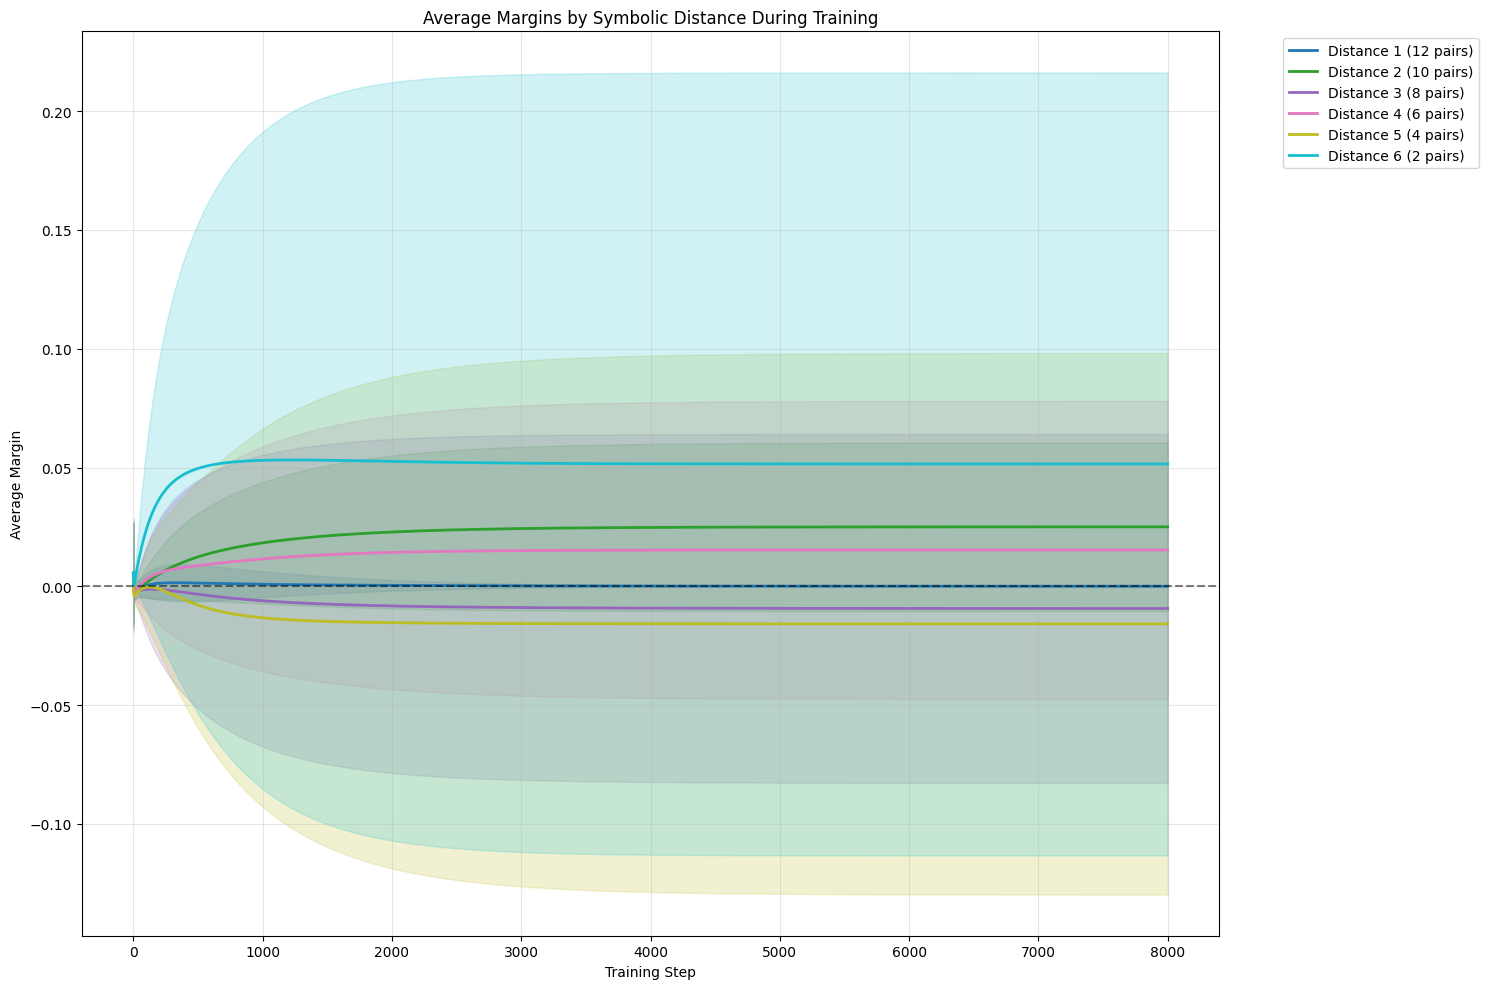

/tmp/ipython-input-1509353530.py:90: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=[f'Dist {d}' for d in valid_distances])


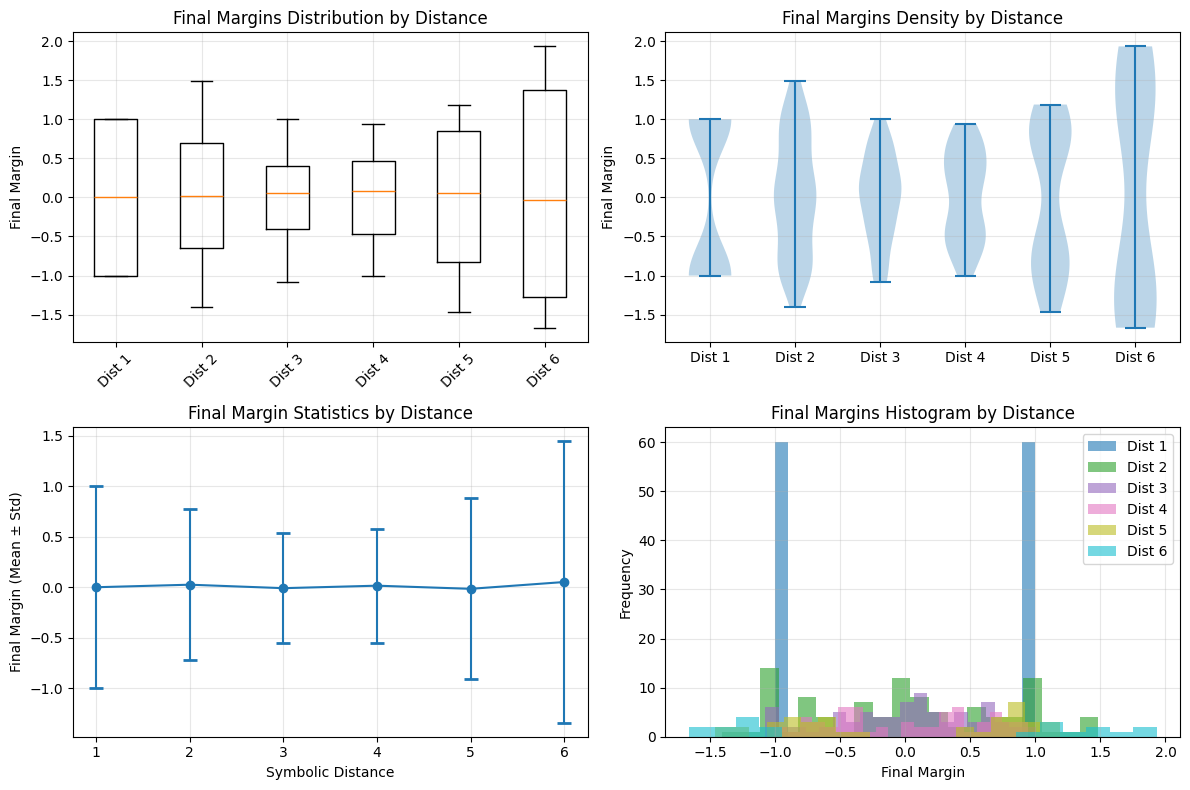

/tmp/ipython-input-1509353530.py:195: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(final_margins_by_pair, labels=pair_labels)


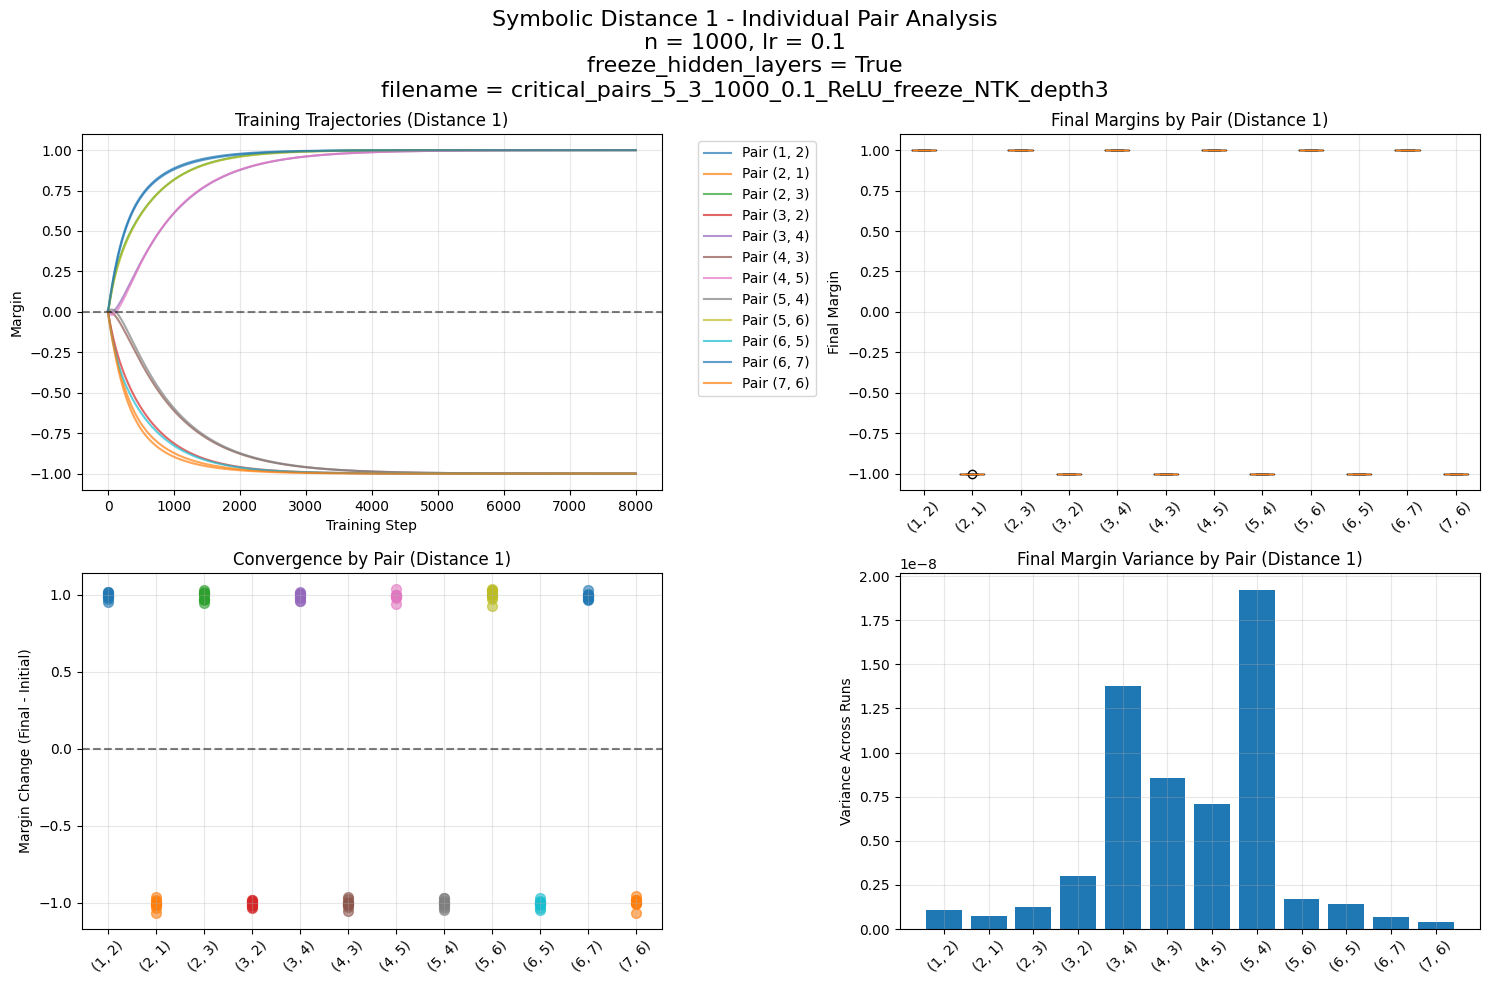

/tmp/ipython-input-1509353530.py:195: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(final_margins_by_pair, labels=pair_labels)


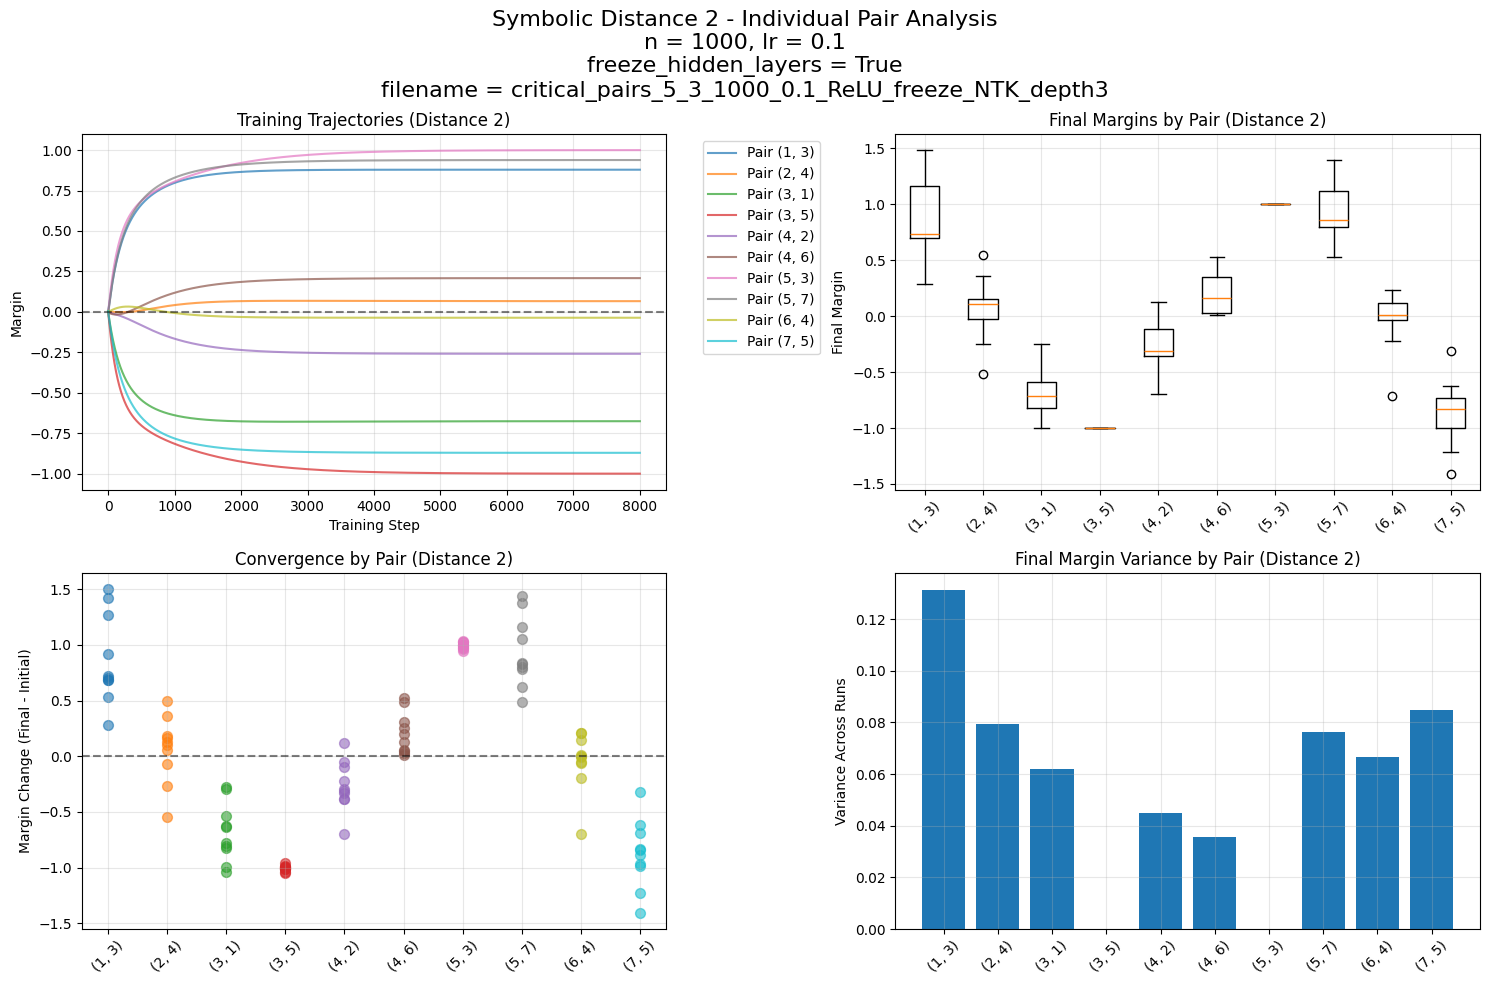

/tmp/ipython-input-1509353530.py:195: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(final_margins_by_pair, labels=pair_labels)


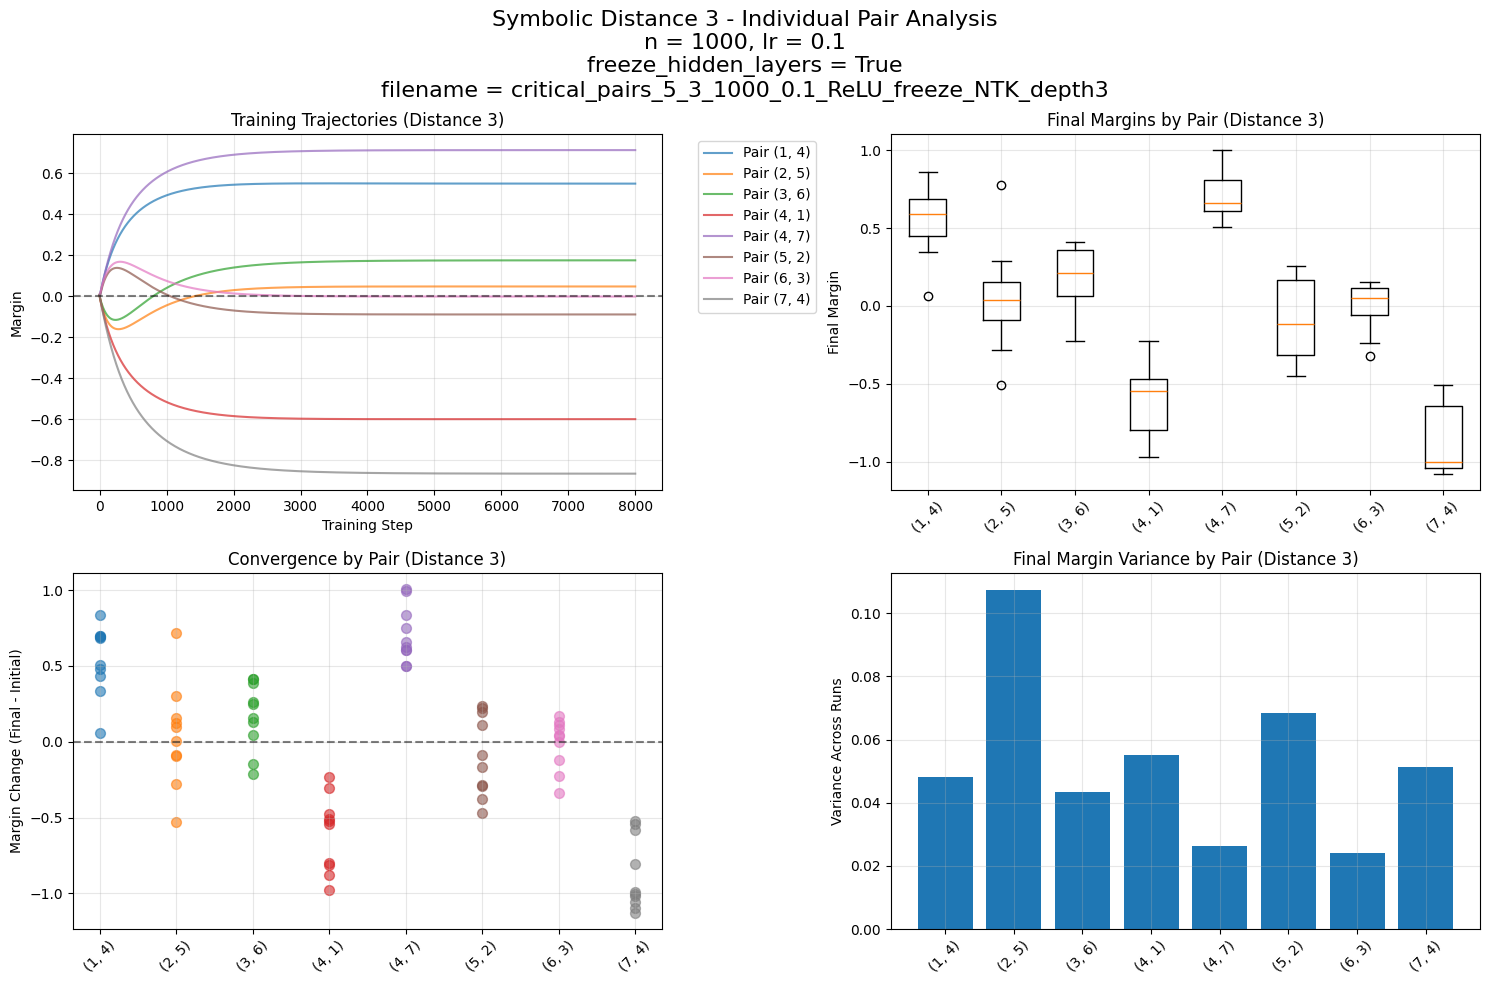

/tmp/ipython-input-1509353530.py:195: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(final_margins_by_pair, labels=pair_labels)


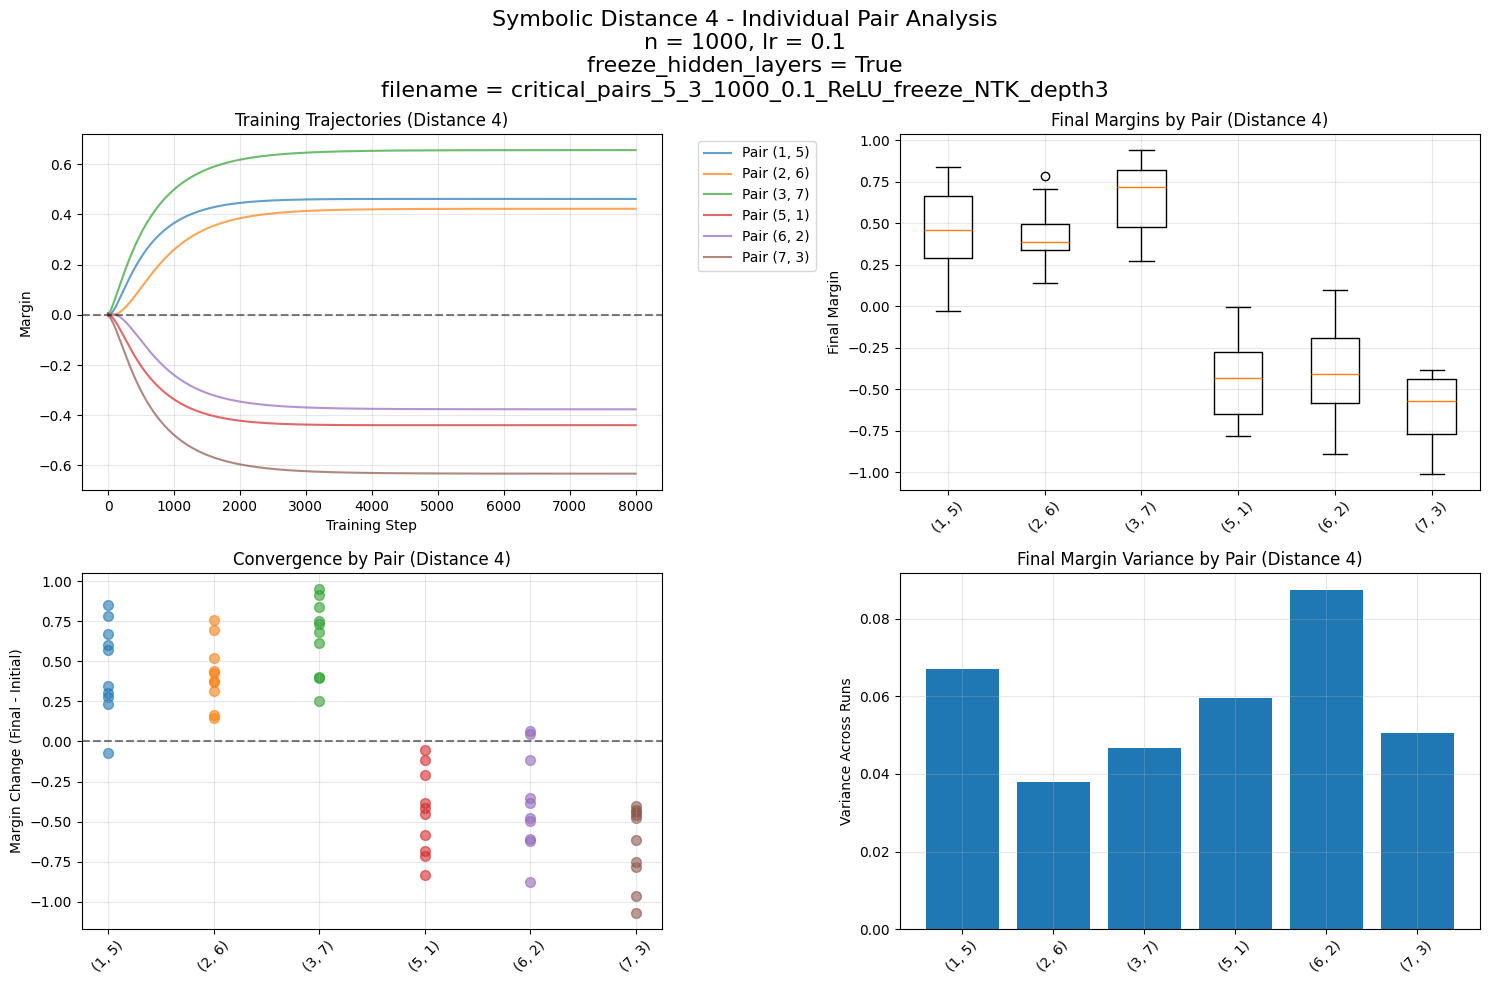

/tmp/ipython-input-1509353530.py:195: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(final_margins_by_pair, labels=pair_labels)


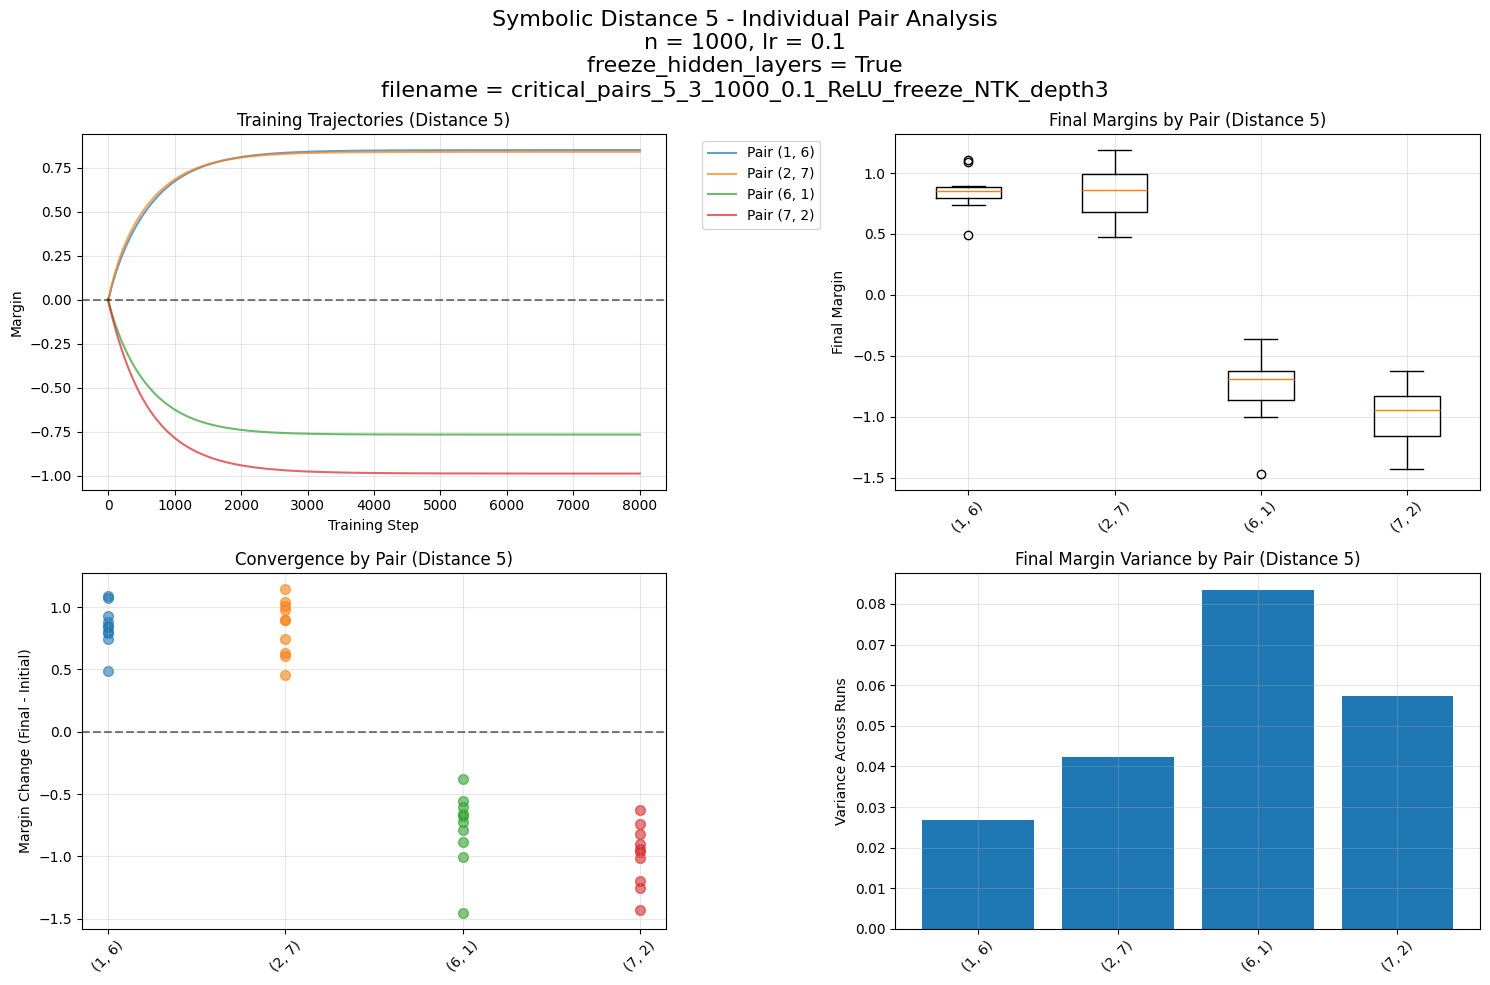

/tmp/ipython-input-1509353530.py:195: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(final_margins_by_pair, labels=pair_labels)


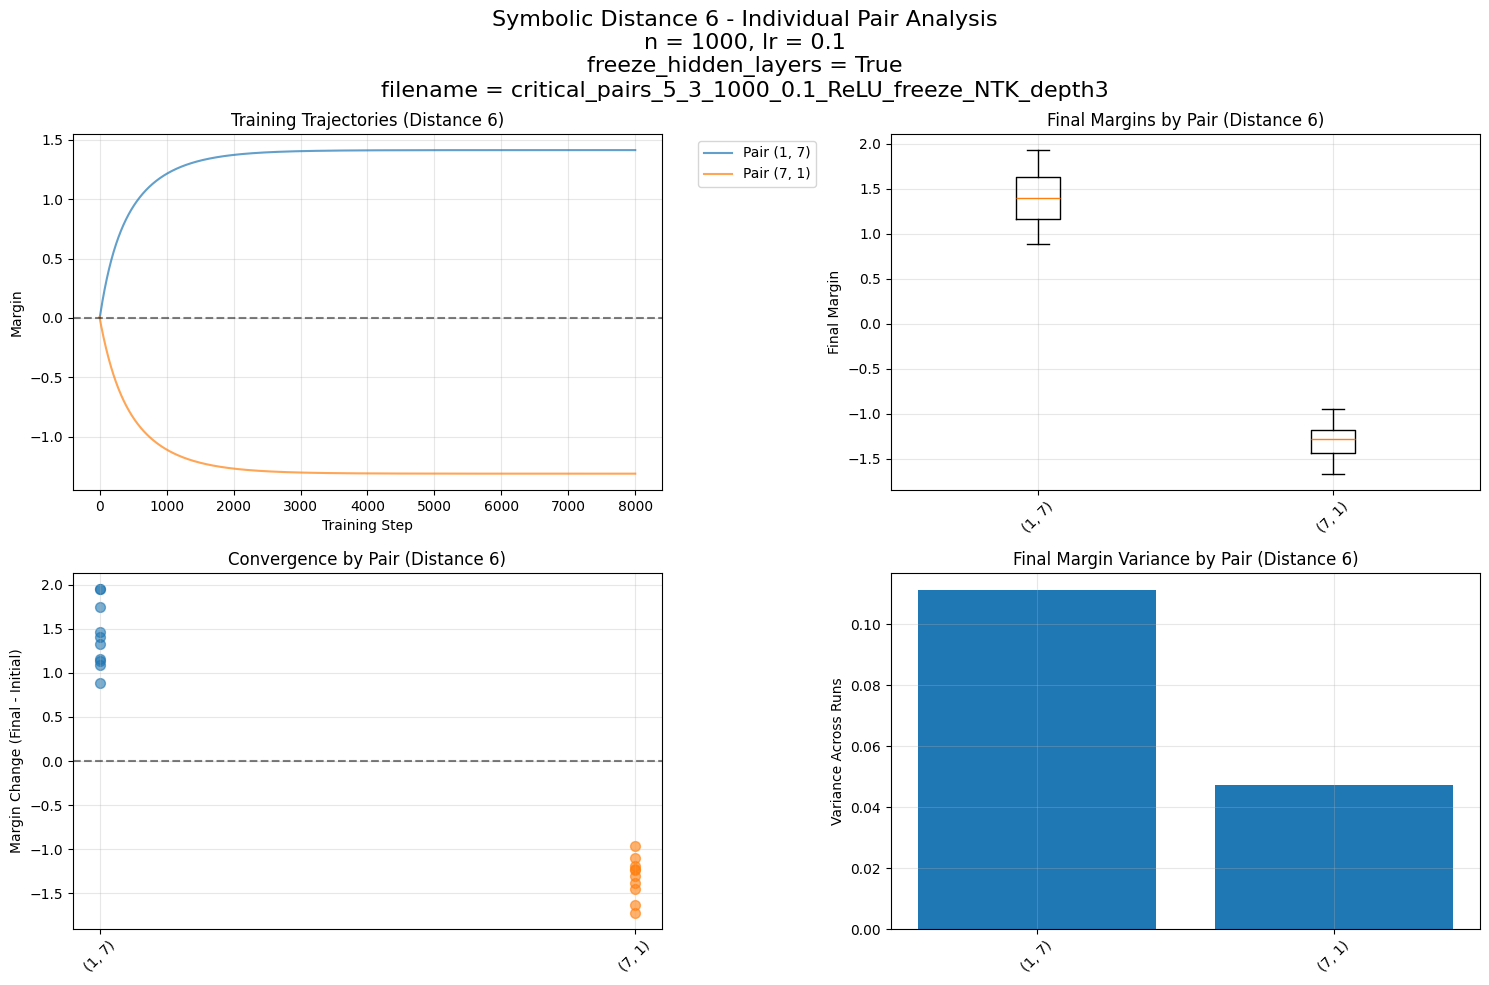


SYMBOLIC DISTANCE ANALYSIS SUMMARY

Distance 1 (12 pairs): [(1, 2), (2, 1), (2, 3), (3, 2), (3, 4), (4, 3), (4, 5), (5, 4), (5, 6), (6, 5), (6, 7), (7, 6)]
  Final margins - Mean: 0.0000, Std: 0.9999
  Final margins - Min: -1.0001, Max: 1.0001
  Condition n - sd = 7 - 1 = 6

Distance 2 (10 pairs): [(1, 3), (2, 4), (3, 1), (3, 5), (4, 2), (4, 6), (5, 3), (5, 7), (6, 4), (7, 5)]
  Final margins - Mean: 0.0250, Std: 0.7455
  Final margins - Min: -1.4081, Max: 1.4845
  Condition n - sd = 7 - 2 = 5

Distance 3 (8 pairs): [(1, 4), (2, 5), (3, 6), (4, 1), (4, 7), (5, 2), (6, 3), (7, 4)]
  Final margins - Mean: -0.0094, Std: 0.5453
  Final margins - Min: -1.0780, Max: 1.0006
  Condition n - sd = 7 - 3 = 4

Distance 4 (6 pairs): [(1, 5), (2, 6), (3, 7), (5, 1), (6, 2), (7, 3)]
  Final margins - Mean: 0.0153, Std: 0.5634
  Final margins - Min: -1.0090, Max: 0.9393
  Condition n - sd = 7 - 4 = 3

Distance 5 (4 pairs): [(1, 6), (2, 7), (6, 1), (7, 2)]
  Final margins - Mean: -0.0158, Std: 0.8950


In [ ]:
# -----------------------------
# Symbolic Distance Analysis and Plotting
# -----------------------------

def analyze_margins_by_distance(csv_path_symbolic, pairs_by_distance, valid_distances):
    """Analyze and plot margin data by symbolic distance"""

    # Load the enhanced CSV data
    df_symbolic = pd.read_csv(csv_path_symbolic)

    # Get unique runs
    unique_runs = df_symbolic['run'].unique()
    num_runs = len(unique_runs)

    print(f"Analyzing margin data from {csv_path_symbolic}")
    print(f"Runs: {num_runs}, Total rows: {len(df_symbolic)}")
    print("="*60)

    # 1. Plot average margins by distance over training
    plt.figure(figsize=(15, 10))

    colors = plt.cm.tab10(np.linspace(0, 1, len(valid_distances)))

    for idx, distance in enumerate(valid_distances):
        pairs = pairs_by_distance[distance]

        # Get column names for this distance
        pair_columns = [f"pair_{pair[0]}_{pair[1]}_dist_{distance}" for pair in pairs]

        # Calculate average margin across all pairs of this distance for each step
        all_steps = []
        all_avg_margins = []

        for run in unique_runs:
            run_data = df_symbolic[df_symbolic['run'] == run]
            steps = run_data['step'].values

            # Average across all pairs of this distance
            avg_margins = run_data[pair_columns].mean(axis=1).values

            all_steps.extend(steps)
            all_avg_margins.extend(avg_margins)

        # Group by step and calculate mean across runs
        step_margins = defaultdict(list)
        for step, margin in zip(all_steps, all_avg_margins):
            step_margins[step].append(margin)

        steps_sorted = sorted(step_margins.keys())
        mean_margins = [np.mean(step_margins[step]) for step in steps_sorted]
        std_margins = [np.std(step_margins[step]) for step in steps_sorted]

        # Plot with error bands
        plt.plot(steps_sorted, mean_margins, color=colors[idx],
                label=f'Distance {distance} ({len(pairs)} pairs)', linewidth=2)
        plt.fill_between(steps_sorted,
                        np.array(mean_margins) - np.array(std_margins),
                        np.array(mean_margins) + np.array(std_margins),
                        color=colors[idx], alpha=0.2)

    plt.xlabel('Training Step')
    plt.ylabel('Average Margin')
    plt.title('Average Margins by Symbolic Distance During Training')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # 2. Final margins distribution by distance
    plt.figure(figsize=(12, 8))

    final_margins_by_distance = {}

    for distance in valid_distances:
        pairs = pairs_by_distance[distance]
        pair_columns = [f"pair_{pair[0]}_{pair[1]}_dist_{distance}" for pair in pairs]

        final_margins = []
        for run in unique_runs:
            run_data = df_symbolic[df_symbolic['run'] == run]
            final_step_data = run_data.iloc[-1]  # Last step
            final_margins.extend(final_step_data[pair_columns].values)

        final_margins_by_distance[distance] = final_margins

    # Box plot
    plt.subplot(2, 2, 1)
    box_data = [final_margins_by_distance[d] for d in valid_distances]
    plt.boxplot(box_data, labels=[f'Dist {d}' for d in valid_distances])
    plt.ylabel('Final Margin')
    plt.title('Final Margins Distribution by Distance')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    # Violin plot
    plt.subplot(2, 2, 2)
    positions = range(1, len(valid_distances) + 1)
    parts = plt.violinplot(box_data, positions=positions)
    plt.xticks(positions, [f'Dist {d}' for d in valid_distances])
    plt.ylabel('Final Margin')
    plt.title('Final Margins Density by Distance')
    plt.grid(True, alpha=0.3)

    # Mean and std by distance
    plt.subplot(2, 2, 3)
    means = [np.mean(final_margins_by_distance[d]) for d in valid_distances]
    stds = [np.std(final_margins_by_distance[d]) for d in valid_distances]

    plt.errorbar(valid_distances, means, yerr=stds, marker='o', capsize=5, capthick=2)
    plt.xlabel('Symbolic Distance')
    plt.ylabel('Final Margin (Mean ± Std)')
    plt.title('Final Margin Statistics by Distance')
    plt.grid(True, alpha=0.3)

    # Histogram of all final margins
    plt.subplot(2, 2, 4)
    for idx, distance in enumerate(valid_distances):
        plt.hist(final_margins_by_distance[distance], alpha=0.6,
                label=f'Dist {distance}', bins=20, color=colors[idx])
    plt.xlabel('Final Margin')
    plt.ylabel('Frequency')
    plt.title('Final Margins Histogram by Distance')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 3. Individual pair analysis for each distance
    for distance in valid_distances:
        pairs = pairs_by_distance[distance]
        if len(pairs) <= 12:  # Only plot if manageable number of pairs

            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            fig.suptitle(
                f'Symbolic Distance {distance} - Individual Pair Analysis\n'
                f'n = {hidden}, lr = {lr}\n'
                f'freeze_hidden_layers = {freeze_hidden_layers}\n'
                f'filename = {CSV_FILENAME}',
                fontsize=16,
                ha='center'
            )

            # Plot 1: All pairs trajectories
            ax = axes[0, 0]
            for pair in pairs:
                pair_col = f"pair_{pair[0]}_{pair[1]}_dist_{distance}"

                # Average across runs
                all_steps = []
                all_margins = []

                for run in unique_runs:
                    run_data = df_symbolic[df_symbolic['run'] == run]
                    steps = run_data['step'].values
                    margins = run_data[pair_col].values
                    all_steps.extend(steps)
                    all_margins.extend(margins)

                # Group by step
                step_margins = defaultdict(list)
                for step, margin in zip(all_steps, all_margins):
                    step_margins[step].append(margin)

                steps_sorted = sorted(step_margins.keys())
                mean_margins = [np.mean(step_margins[step]) for step in steps_sorted]

                ax.plot(steps_sorted, mean_margins, label=f'Pair {pair}', alpha=0.7)

            ax.set_xlabel('Training Step')
            ax.set_ylabel('Margin')
            ax.set_title(f'Training Trajectories (Distance {distance})')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.grid(True, alpha=0.3)
            ax.axhline(0, color='black', linestyle='--', alpha=0.5)

            # Plot 2: Final margins by pair
            ax = axes[0, 1]
            final_margins_by_pair = []
            pair_labels = []

            for pair in pairs:
                pair_col = f"pair_{pair[0]}_{pair[1]}_dist_{distance}"
                final_margins = []

                for run in unique_runs:
                    run_data = df_symbolic[df_symbolic['run'] == run]
                    final_margin = run_data[pair_col].iloc[-1]
                    final_margins.append(final_margin)

                final_margins_by_pair.append(final_margins)
                pair_labels.append(f'{pair}')

            ax.boxplot(final_margins_by_pair, labels=pair_labels)
            ax.set_ylabel('Final Margin')
            ax.set_title(f'Final Margins by Pair (Distance {distance})')
            ax.grid(True, alpha=0.3)
            plt.setp(ax.get_xticklabels(), rotation=45)

            # Plot 3: Convergence analysis
            ax = axes[1, 0]
            for pair in pairs:
                pair_col = f"pair_{pair[0]}_{pair[1]}_dist_{distance}"

                convergence_rates = []
                for run in unique_runs:
                    run_data = df_symbolic[df_symbolic['run'] == run]
                    margins = run_data[pair_col].values

                    # Simple convergence metric: final vs initial
                    if len(margins) > 1:
                        convergence = margins[-1] - margins[0]
                        convergence_rates.append(convergence)

                if convergence_rates:
                    ax.scatter([str(pair)] * len(convergence_rates), convergence_rates,
                              alpha=0.6, s=50)

            ax.set_ylabel('Margin Change (Final - Initial)')
            ax.set_title(f'Convergence by Pair (Distance {distance})')
            ax.grid(True, alpha=0.3)
            ax.axhline(0, color='black', linestyle='--', alpha=0.5)
            plt.setp(ax.get_xticklabels(), rotation=45)

            # Plot 4: Variance across runs
            ax = axes[1, 1]
            variances = []
            pair_labels_var = []

            for pair in pairs:
                pair_col = f"pair_{pair[0]}_{pair[1]}_dist_{distance}"
                final_margins = []

                for run in unique_runs:
                    run_data = df_symbolic[df_symbolic['run'] == run]
                    final_margin = run_data[pair_col].iloc[-1]
                    final_margins.append(final_margin)

                variance = np.var(final_margins)
                variances.append(variance)
                pair_labels_var.append(str(pair))

            ax.bar(pair_labels_var, variances)
            ax.set_ylabel('Variance Across Runs')
            ax.set_title(f'Final Margin Variance by Pair (Distance {distance})')
            ax.grid(True, alpha=0.3)
            plt.setp(ax.get_xticklabels(), rotation=45)

            plt.tight_layout()
            plt.show()

    # 4. Summary statistics table
    print("\n" + "="*80)
    print("SYMBOLIC DISTANCE ANALYSIS SUMMARY")
    print("="*80)

    for distance in valid_distances:
        pairs = pairs_by_distance[distance]
        pair_columns = [f"pair_{pair[0]}_{pair[1]}_dist_{distance}" for pair in pairs]

        final_margins = []
        for run in unique_runs:
            run_data = df_symbolic[df_symbolic['run'] == run]
            final_step_data = run_data.iloc[-1]
            final_margins.extend(final_step_data[pair_columns].values)

        print(f"\nDistance {distance} ({len(pairs)} pairs): {pairs}")
        print(f"  Final margins - Mean: {np.mean(final_margins):.4f}, Std: {np.std(final_margins):.4f}")
        print(f"  Final margins - Min: {np.min(final_margins):.4f}, Max: {np.max(final_margins):.4f}")
        print(f"  Condition n - sd = {num_items} - {distance} = {num_items - distance}")

    return final_margins_by_distance

# Run the analysis
final_margins_by_distance = analyze_margins_by_distance(csv_path_symbolic, pairs_by_distance, valid_distances)


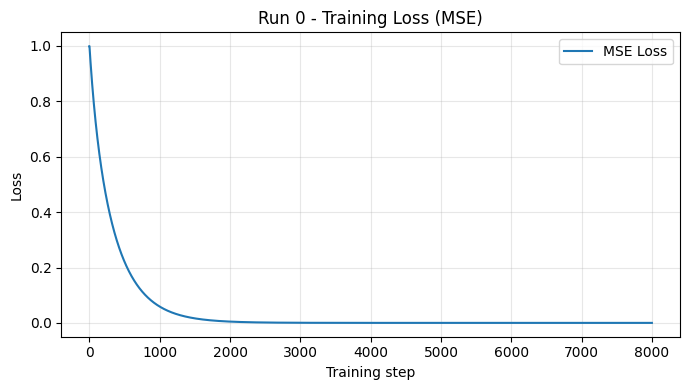

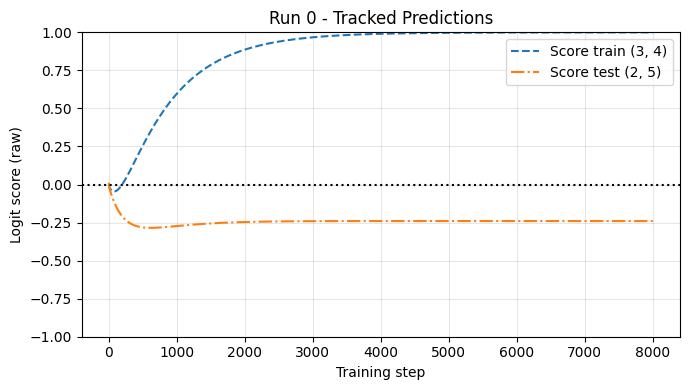

[Run 00] Step 0 MSE: 0.999310


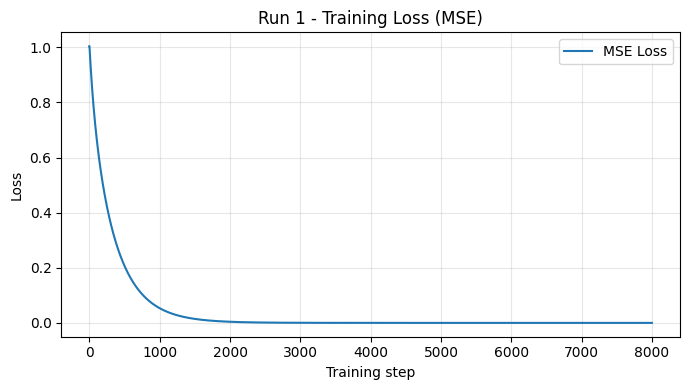

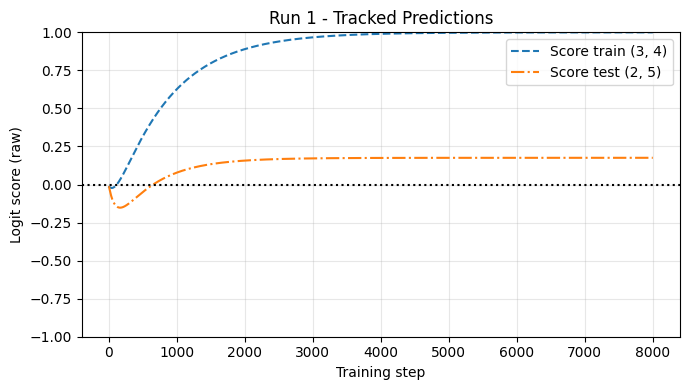

[Run 01] Step 0 MSE: 1.004305


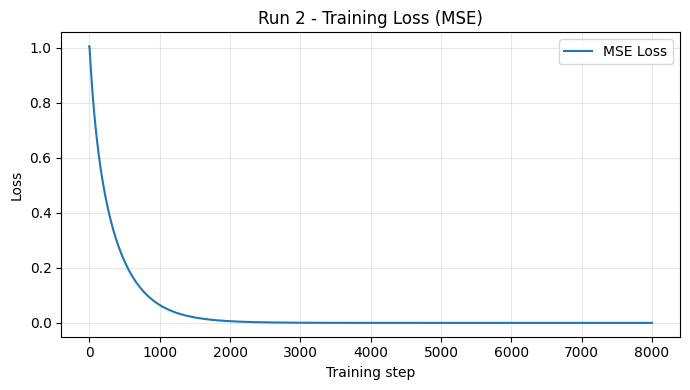

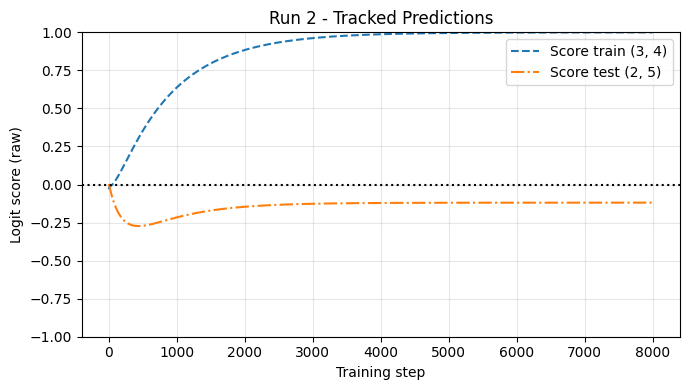

[Run 02] Step 0 MSE: 1.005594


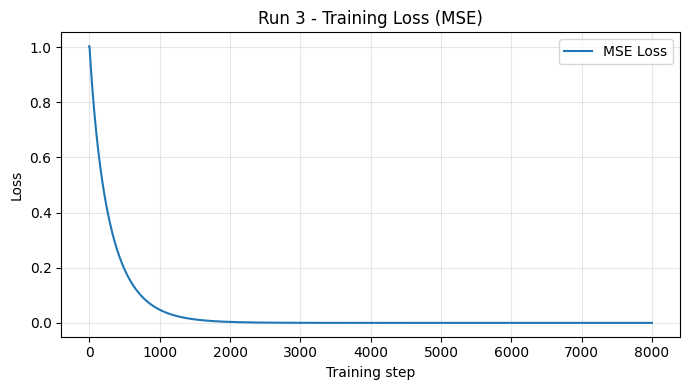

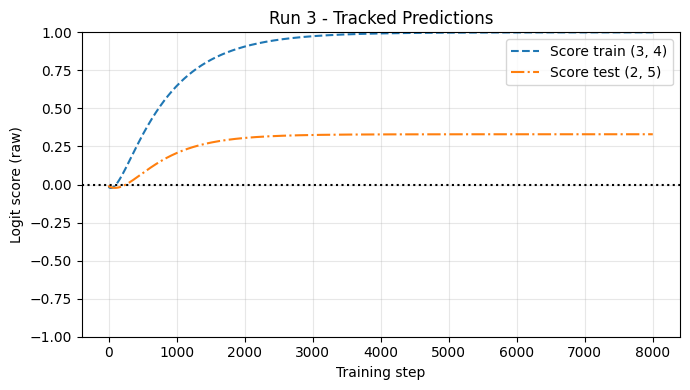

[Run 03] Step 0 MSE: 1.003090


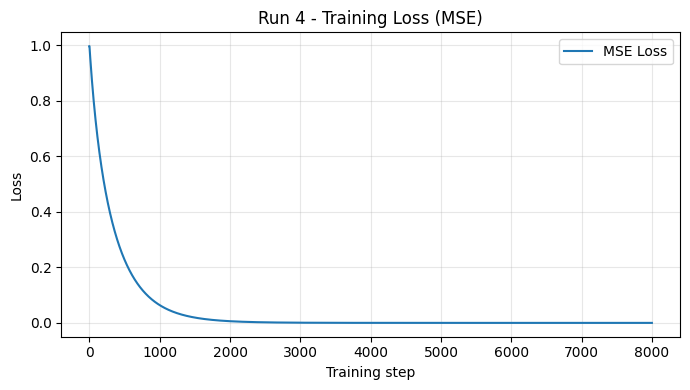

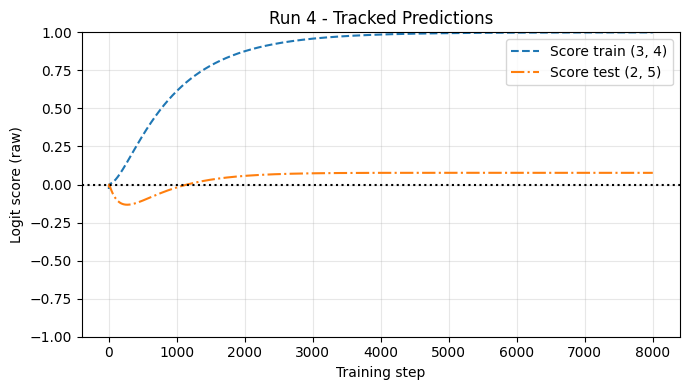

[Run 04] Step 0 MSE: 0.996759


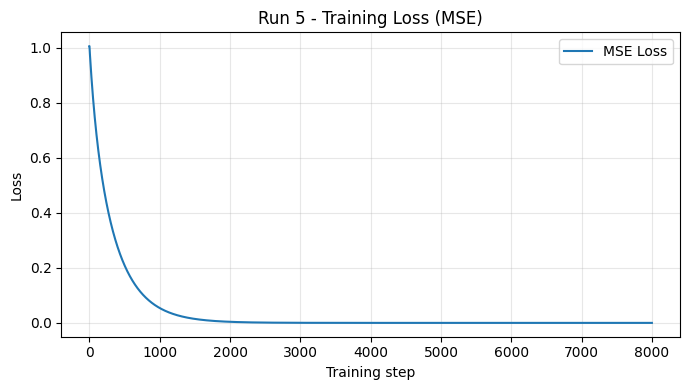

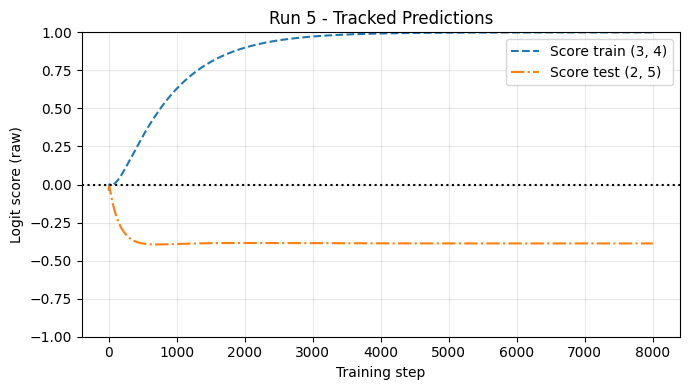

[Run 05] Step 0 MSE: 1.004969


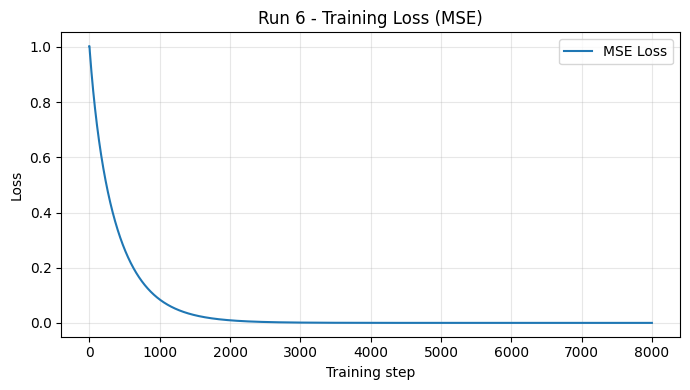

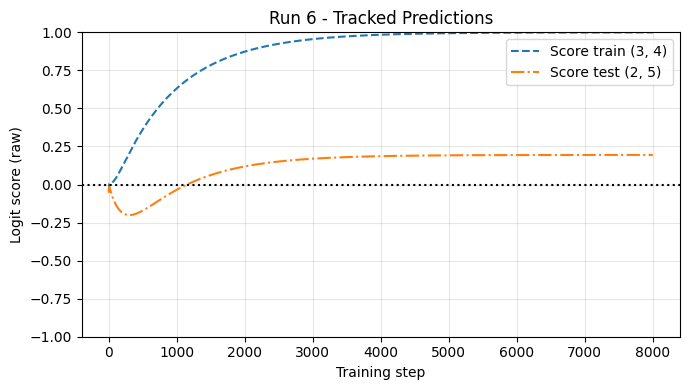

[Run 06] Step 0 MSE: 1.002854


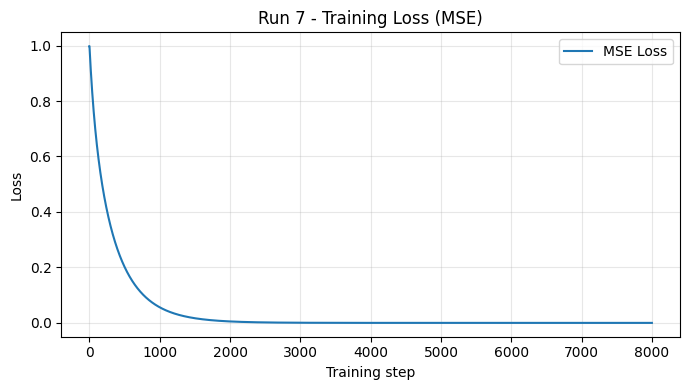

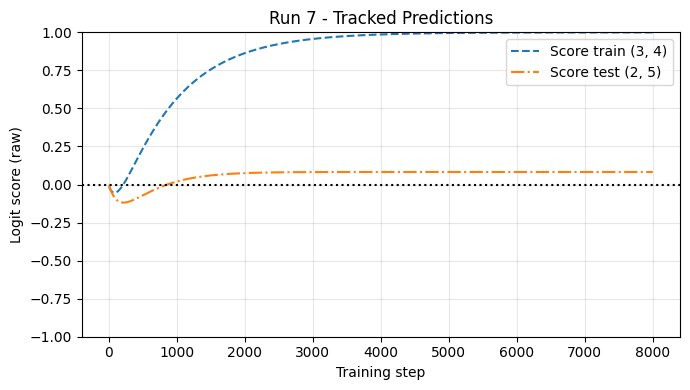

[Run 07] Step 0 MSE: 0.997765


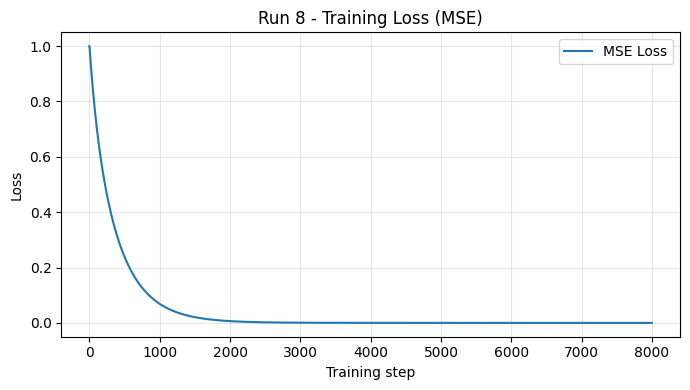

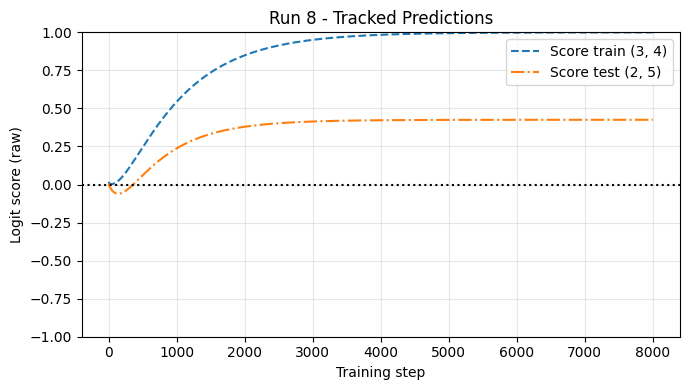

[Run 08] Step 0 MSE: 0.999510


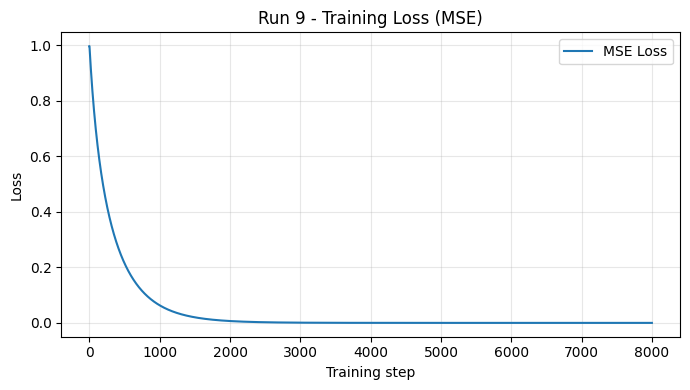

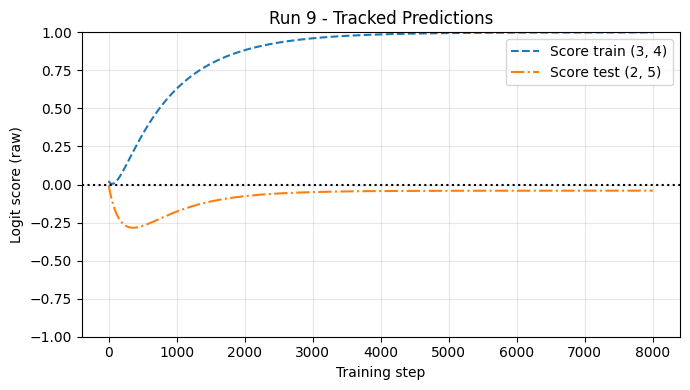

[Run 09] Step 0 MSE: 0.997169


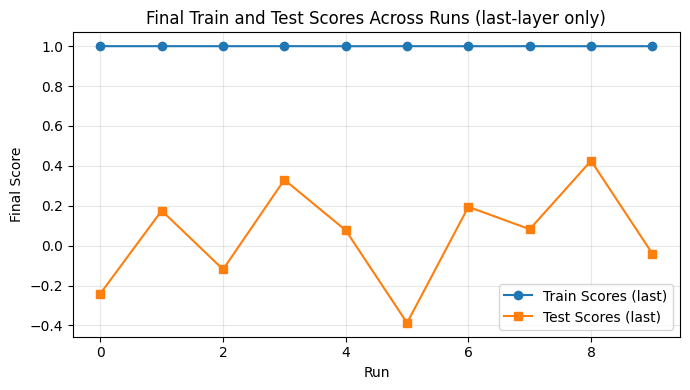

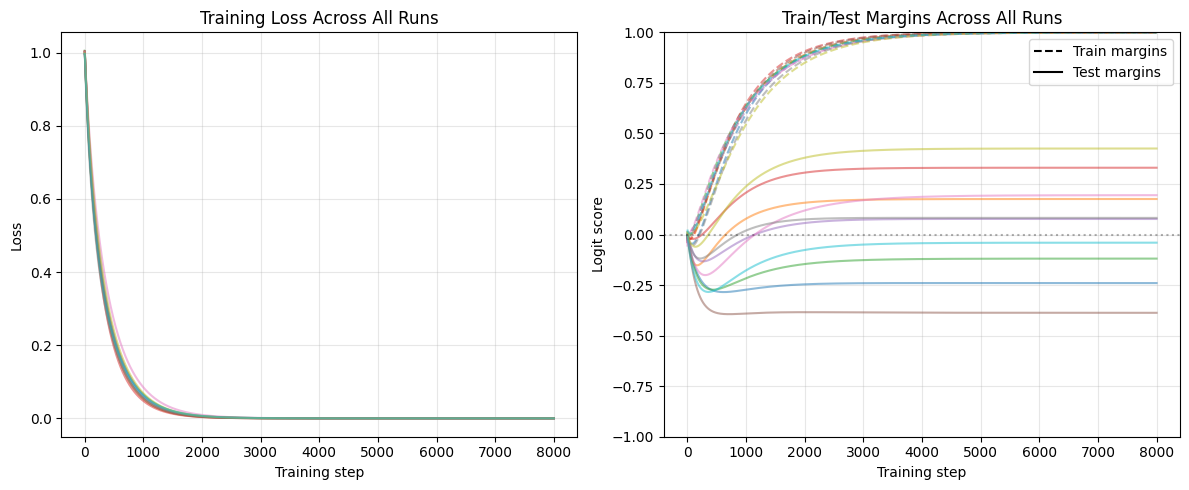


SUMMARY STATISTICS

Final Train Scores (pair 3,4):
  Mean: 0.9998
  Std:  0.0001
  Min:  0.9997
  Max:  1.0000

Final Test Scores (pair 2,5):
  Mean: 0.0498
  Std:  0.2387
  Min:  -0.3872
  Max:  0.4254

CONVERGENCE ANALYSIS

Run 0:
  Initial loss: 0.999310
  Final loss:   0.000000
  Reduction:    100.0%

Run 1:
  Initial loss: 1.004305
  Final loss:   0.000000
  Reduction:    100.0%

Run 2:
  Initial loss: 1.005594
  Final loss:   0.000000
  Reduction:    100.0%

Run 3:
  Initial loss: 1.003090
  Final loss:   0.000000
  Reduction:    100.0%

Run 4:
  Initial loss: 0.996759
  Final loss:   0.000000
  Reduction:    100.0%

Run 5:
  Initial loss: 1.004969
  Final loss:   0.000000
  Reduction:    100.0%

Run 6:
  Initial loss: 1.002854
  Final loss:   0.000000
  Reduction:    100.0%

Run 7:
  Initial loss: 0.997765
  Final loss:   0.000000
  Reduction:    100.0%

Run 8:
  Initial loss: 0.999510
  Final loss:   0.000000
  Reduction:    100.0%

Run 9:
  Initial loss: 0.997169
  Final loss

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# -----------------------------
# Load the CSV data
# -----------------------------
csv_path = f"run_csvs/{CSV_FILENAME}.csv"

# Read the CSV file
df = pd.read_csv(csv_path)

# Get unique runs
unique_runs = df['run'].unique()
num_runs = len(unique_runs)

# -----------------------------
# Plot individual runs
# -----------------------------
for run in unique_runs:
    # Filter data for this run
    run_data = df[df['run'] == run]

    # Extract columns
    steps = run_data['step'].values
    losses = run_data['loss'].values
    train_margins = run_data['train_margin'].values
    test_margins = run_data['test_margin'].values

    # Plot 1: Loss curve
    plt.figure(figsize=(7, 4))
    plt.plot(steps, losses, label="MSE Loss")
    plt.xlabel("Training step")
    plt.ylabel("Loss")
    plt.title(f"Run {run} - Training Loss (MSE)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 2: Train and test scores
    plt.figure(figsize=(7, 4))
    plt.plot(steps, train_margins, '--', label=f"Score train (3, 4)")  # q=3, q+1=4
    plt.plot(steps, test_margins, '-.', label=f"Score test (2, 5)")   # q-1=2, p=5
    plt.xlabel("Training step")
    plt.ylabel("Logit score (raw)")
    plt.title(f"Run {run} - Tracked Predictions")
    plt.axhline(0, color='k', linestyle=':')
    plt.grid(True, alpha=0.3)
    plt.ylim(-1, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print initial loss for this run
    initial_loss = losses[0]
    print(f"[Run {run:02d}] Step 0 MSE: {initial_loss:.6f}")

# -----------------------------
# Summary plot across all runs
# -----------------------------
# Get the final scores for each run
train_scores_last = []
test_scores_last = []

for run in unique_runs:
    run_data = df[df['run'] == run]
    # Get the last row for this run
    last_train = run_data['train_margin'].iloc[-1]
    last_test = run_data['test_margin'].iloc[-1]
    train_scores_last.append(last_train)
    test_scores_last.append(last_test)

# Plot summary
plt.figure(figsize=(7, 4))
plt.plot(train_scores_last, marker='o', label='Train Scores (last)')
plt.plot(test_scores_last, marker='s', label='Test Scores (last)')
plt.xlabel("Run")
plt.ylabel("Final Score")
plt.title("Final Train and Test Scores Across Runs (last-layer only)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# Additional analysis plots
# -----------------------------

# Plot all runs on same axes for comparison
plt.figure(figsize=(12, 5))

# Subplot 1: All loss curves
plt.subplot(1, 2, 1)
for run in unique_runs:
    run_data = df[df['run'] == run]
    plt.plot(run_data['step'], run_data['loss'], alpha=0.5, label=f'Run {run}')
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Training Loss Across All Runs")
plt.grid(True, alpha=0.3)
if num_runs <= 5:  # Only show legend if not too many runs
    plt.legend()

# Subplot 2: All train/test margins
plt.subplot(1, 2, 2)
for run in unique_runs:
    run_data = df[df['run'] == run]
    plt.plot(run_data['step'], run_data['train_margin'], '--', alpha=0.5, color=f'C{run}')
    plt.plot(run_data['step'], run_data['test_margin'], '-', alpha=0.5, color=f'C{run}')

# Add dummy lines for legend
plt.plot([], [], 'k--', label='Train margins')
plt.plot([], [], 'k-', label='Test margins')
plt.xlabel("Training step")
plt.ylabel("Logit score")
plt.title("Train/Test Margins Across All Runs")
plt.axhline(0, color='k', linestyle=':', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.ylim(-1, 1)
plt.legend()

plt.tight_layout()
plt.show()

# -----------------------------
# Statistics summary
# -----------------------------
print("\n" + "="*50)
print("SUMMARY STATISTICS")
print("="*50)

# Final scores statistics
train_final = np.array(train_scores_last)
test_final = np.array(test_scores_last)

print(f"\nFinal Train Scores (pair 3,4):")
print(f"  Mean: {train_final.mean():.4f}")
print(f"  Std:  {train_final.std():.4f}")
print(f"  Min:  {train_final.min():.4f}")
print(f"  Max:  {train_final.max():.4f}")

print(f"\nFinal Test Scores (pair 2,5):")
print(f"  Mean: {test_final.mean():.4f}")
print(f"  Std:  {test_final.std():.4f}")
print(f"  Min:  {test_final.min():.4f}")
print(f"  Max:  {test_final.max():.4f}")

# Convergence analysis
print(f"\n{'='*50}")
print("CONVERGENCE ANALYSIS")
print("="*50)

for run in unique_runs:
    run_data = df[df['run'] == run]
    final_loss = run_data['loss'].iloc[-1]
    initial_loss = run_data['loss'].iloc[0]
    loss_reduction = (initial_loss - final_loss) / initial_loss * 100

    print(f"\nRun {run}:")
    print(f"  Initial loss: {initial_loss:.6f}")
    print(f"  Final loss:   {final_loss:.6f}")
    print(f"  Reduction:    {loss_reduction:.1f}%")

# Overall loss statistics
all_final_losses = [df[df['run'] == r]['loss'].iloc[-1] for r in unique_runs]
print(f"\nFinal Loss Statistics Across Runs:")
print(f"  Mean: {np.mean(all_final_losses):.6f}")
print(f"  Std:  {np.std(all_final_losses):.6f}")

print("\n" + "="*50)
print("Plotting complete!")
print("="*50)